In [101]:
import zipfile
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error as mse
from sklearn import preprocessing
import os
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from scipy.stats import norm
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler

### Extracting from the zip file

In [3]:
with zipfile.ZipFile('superconduct.zip', 'r') as zip_ref:
    zip_ref.extractall("out1")

### Opening the files and combining them

In [4]:
train_initial = pd.read_csv('out1/train.csv') 
unique_m_initial = pd.read_csv('out1/unique_m.csv')
merged = pd.concat([train_initial, unique_m_initial.iloc[:,:-1]], axis=1)
merged = merged.loc[:,~merged.columns.duplicated()]
# deleting duplicated column as well

In [5]:
#check if there are non-numerical characters in columns
merged.dtypes[merged.dtypes != 'int64'][merged.dtypes != 'float64']

#Seems like not

Series([], dtype: object)

### Splitting into train and test

In [322]:
X_train, X_test, y_train, y_test = train_test_split (merged.iloc[:,:-1], pd.Series(merged.critical_temp), train_size = 0.6, random_state=10)

### Standartization of the train data

In [ ]:
### Checking what would happen without standartization

In [ ]:
##Building linear model

In [118]:
reg = LinearRegression()
reg.fit (X_train, y_train)
y_pred = reg.predict (X_test)

In [ ]:
##Checking the R score - it is 1 

In [119]:
print (reg.score(X_train, y_train), 1 - (1-reg.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))

1.0 1.0


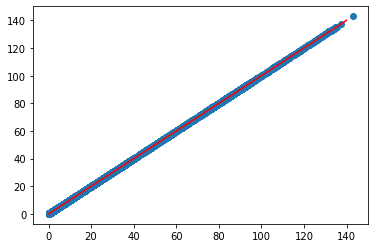

In [120]:
plt.scatter (y_test, y_pred)
plt.plot ([0, 140], [0, 140], c = 'r')
#comparing the result with ideal one. It seems good but likely not very informative because of the numbers

### Standartization

In [323]:
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

### PCA with all components

In [351]:
X_train, X_test, y_train, y_test = train_test_split (merged.iloc[:,:-1], pd.Series(merged.critical_temp), train_size = 0.6, random_state=10)
sc = StandardScaler()
#sc.fit(X_train)
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
pca = PCA(n_components = X_train.shape[1])
#pca.fit(X_train)
X_train = pca.fit_transform (X_train)
X_test = pca.transform (X_test)
reg = LinearRegression()
reg.fit (X_train, y_train)
y_pred = reg.predict (X_test)

In [353]:
print (reg.score(X_train, y_train), 1 - (1-reg.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))

1.0 1.0


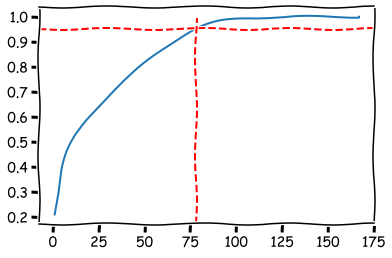

In [352]:
ths = 0.95
total_explained = np.cumsum(pca.explained_variance_ratio_)


with plt.xkcd():
    plt.plot(np.arange(1, total_explained.shape[0] + 1), total_explained)
    plt.axhline(xmin=0, xmax=1000, y=ths, c="red", ls="--")
    chosen_number = np.where(total_explained >= 0.95)[0][0] + 1
    plt.axvline(x=chosen_number, ymin=0, ymax=ths, c="red", ls="--")
    plt.text(800, 0.7, f"n PCs = {chosen_number}", clip_on=True);

In [ ]:
#Code from the lecture to try to define the optimal number of components

In [393]:
def shuffle_dataset(dataset):
    """
    Мешаем данные
    """
    random_data =  {}
    for col in dataset.columns:
        random_data[col] = np.random.permutation(dataset.loc[:, col].values)
    random_data = pd.DataFrame(random_data)
    
    return random_data


def get_variance_by_chance(dataset, n_replics, n_components):
    """
    Считаем, сколько дисперсии объясняет каждая PC для перемешанных данных
    """
    variance_explained_by_chance = np.zeros((n_replics, n_components))
    
    for i in tqdm.tqdm_notebook(range(n_replics)):
        if i % 100 == 0:
            print(f"{i} iter")

        random_data = shuffle_dataset(dataset)
        random_pca = PCA(n_components=n_components)
        random_pca.fit(random_data)
        variance_explained_by_chance[i, :] = random_pca.explained_variance_ratio_
        
    return variance_explained_by_chance


def get_pc_variance(dataset, n_components):
    """
    Считаем, сколько дисперсии объясняет каждая PC для реальных данных
    """
    pca = PCA(n_components=n_components)
    pca.fit(dataset)
    
    return pca.explained_variance_ratio_


# Дальше идет ряд графиков для визуализации

def plot_mean_and_ci(ax, values, label, ci_level=0.95, alpha_transparency=0.5, color_mean=None, color_shading=None):
    mean = values.mean(axis=0)
    
    std = values.std(axis=0)
    n = values.shape[1]
    se = std / np.sqrt(n) 
    
    q_alpha = (1-ci_level) / 2
    ci_num = np.abs(norm.ppf(q_alpha, loc=0, scale=1))
    
    lb = mean -  ci_num * se
    ub = mean + ci_num * se
    
    ax.fill_between(range(mean.shape[0]), ub, lb,
                     color=color_shading, alpha=alpha_transparency)
    
    ax.plot(mean, c=color_mean, lw=3, label=label)
    
    
def plot_explained_variance(ax, variance):
    ax.plot(variance, label="real", lw=3)
    ax.scatter(np.arange(0, variance.shape[0]), variance)
    
    
def plot_variance_by_change(ax, variance_by_chance):
    plot_mean_and_ci(ax, variance_by_chance, label="chance", color_mean="red", color_shading="red")


def plot_explained_vs_chance(ax, explained_variance, variance_by_chance, dataset_name, step=1):
    plot_explained_variance(ax, explained_variance)
    plot_variance_by_change(ax, variance_by_chance)

    ax.set_title(f"PCA {dataset_name}", size=35)
    ax.set_xlabel("Component number", size=25)
    ax.set_ylabel("Explained variance ratio", size=25)
    ax.set_xticks(np.arange(0, explained_variance.shape[0], step))
    ax.set_xticklabels(np.arange(1, explained_variance.shape[0]+1, step), size=20)

    ax.tick_params(labelsize=20, size=10)
    ax.set_ylim(0, explained_variance[0] + 0.1 )
    ax.legend(fontsize=20)

    
def plot_pval_plot(ax, p_values, dataset_name, alpha_level = 0.05, logscale=True, step=1):
    if logscale:
        p_values = -np.log10(p_values)
        alpha_level = -np.log10(alpha_level)

    
    ax.set_title(f"PC significance, {dataset_name}", size=35)
    ax.plot(p_values, lw=3)
    ax.scatter(np.arange(0, p_values.shape[0]), p_values, lw=3)

    ax.set_xlabel("Component number", size=25)
    ax.set_ylabel("-log(pvalue + eps)", size=25)
    ax.set_xticks(np.arange(0, p_values.shape[0], step))
    
    ax.set_xticklabels(labels = np.arange(1, p_values.shape[0]+1, step), size=20)
    ax.tick_params(labelsize=20, size=10)
    

    ax.hlines(y=alpha_level, xmin=0, xmax=p_values.shape[0], color="red", linestyles="dashed", lw=3)


def calc_permutat_pval(real_values, permut_values, eps=None):
    """
    Сравниваем долю объясненной дисперсии для реальных данных и для перемешанных
    """
    eps = eps or (1 / (permut_values.shape[0] * 10))
    
    p_values = np.zeros_like(real_values)
    for i in range(0, p_values.shape[0], 1):
        p_values[i] = (permut_values[:, i] >= real_values[i]).mean() + eps
    return p_values

    
def pca_analysis(ax1, ax2, dataset, title, n_components = None, n_replics = 1000, step=1):
    """
    Главная функция, которая просто запускает все, что выше
    """
    n_components = n_components or dataset.shape[1]
    explained_variance = get_pc_variance(dataset, n_components)
    variance_by_chance = get_variance_by_chance(dataset, n_replics, n_components)
    p_values = calc_permutat_pval(explained_variance, variance_by_chance)
    plot_explained_vs_chance(ax1, explained_variance, variance_by_chance, title)
    plot_pval_plot(ax2, p_values, title)

<ipython-input-82-4800d10539b4>:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm.tqdm_notebook(range(n_replics)):


0 iter



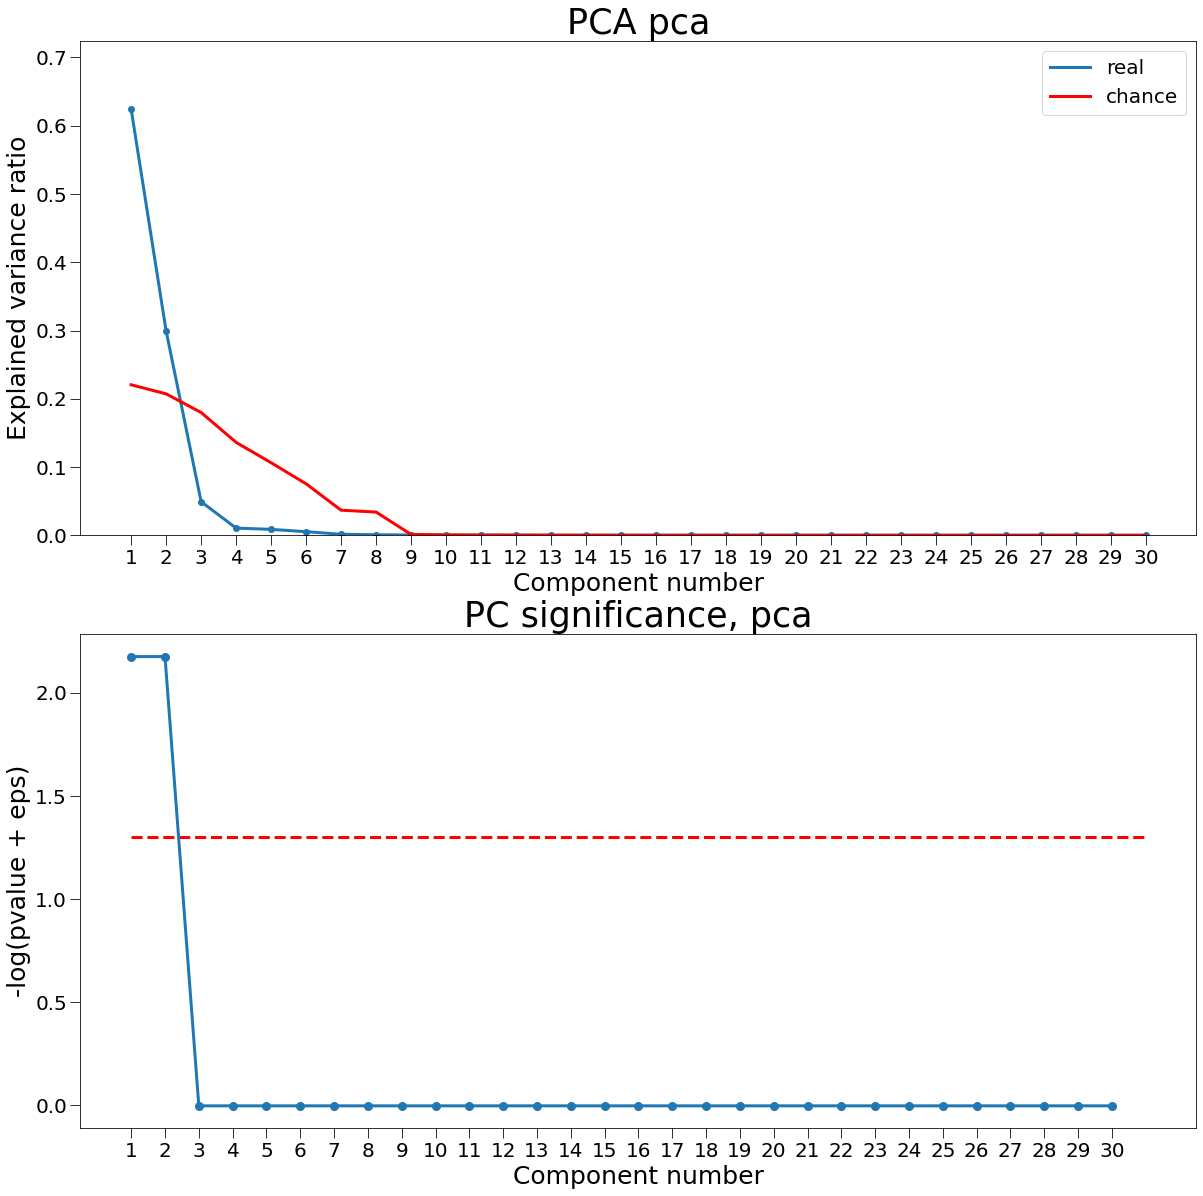

In [328]:
f, (ax1, ax2) = plt.subplots(2, 1)
f.set_figheight(20)
f.set_figwidth(20)
pca_analysis(ax1, ax2, merged.iloc[:, 0:(X_train.shape[1] - 1)], "pca", n_replics=15, n_components=30)

From those pictures it seems like the needed component number is 3.

Checking for the number of components 3:
Standartization -> PCA -> Regression Model

In [376]:
X_train, X_test, y_train, y_test = train_test_split (merged.iloc[:,:-1], pd.Series(merged.critical_temp), train_size = 0.6, random_state=10)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
pca = PCA(n_components = 3)
#pca.fit(X_train)
X_train = pca.fit_transform (X_train)
X_test = pca.transform (X_test)
reg = LinearRegression()
reg.fit (X_train, y_train)
y_pred = reg.predict (X_test)


Adjusted R squared here is 0.54 which is not very good.

In [377]:
print (reg.score(X_train, y_train), 1 - (1-reg.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))

0.536939798396566 0.5368308686855325


Building scatterplot - contrary to the ideal line the results I got do not have a good shape. Maybe it is due to mistakes in scaling or other steps. 

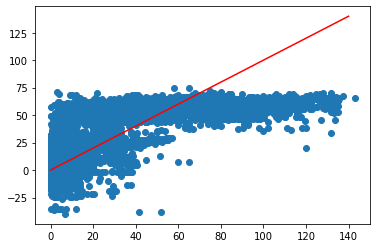

In [378]:
plt.scatter (y_test, y_pred, label = "our model")
plt.plot ([0, 140], [0, 140], c = 'r', label = "ideal")

On original data first 3 components explained around 97% of variance.

In [395]:
#np.cumsum (pca.explained_variance_ratio_)

Better results (adjusted R squared > 75) can only be observed with the number of components around 75. 

In [386]:
X_train, X_test, y_train, y_test = train_test_split (merged.iloc[:,:-1], pd.Series(merged.critical_temp), train_size = 0.6, random_state=10)
sc = StandardScaler()
#sc.fit(X_train)
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
pca = PCA(n_components = 75)
#pca.fit(X_train)
X_train = pca.fit_transform (X_train)
X_test = pca.transform (X_test)
reg = LinearRegression()
reg.fit (X_train, y_train)
y_pred = reg.predict (X_test)

In [387]:
print (reg.score(X_train, y_train), 1 - (1-reg.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))

0.7605927501052525 0.7591768094269065


The scatterplot looks better than the previous one

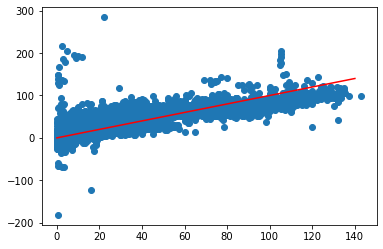

In [390]:
plt.scatter (y_test, y_pred, label = "our model")
plt.plot ([0, 140], [0, 140], c = 'r', label = "ideal")

##Implementing Kernel PCA

In [357]:
from sklearn.decomposition import KernelPCA
X_train, X_test, y_train, y_test = train_test_split (merged.iloc[:,:-1], pd.Series(merged.critical_temp), train_size = 0.6, random_state=10)
sc = StandardScaler()
#sc.fit(X_train)
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
kernel_data = KernelPCA(n_components=3, kernel='rbf')
X_kernel = kernel_data.fit_transform(X_train)
X_kernel_test = kernel_data.transform(X_test)
reg = LinearRegression()
reg.fit (X_kernel, y_train)
y_pred = reg.predict (X_kernel_test)

In [358]:
print (reg.score(X_kernel, y_train), 1 - (1-reg.score(X_kernel, y_train))*(len(y_train)-1)/(len(y_train)-X_kernel.shape[1]-1))

0.4734570073457286 0.47333314402118043


I was not actually able to finish this part with any significant result. Overall, something might have gone wrong during the analysis. The graphs and explained variance ratio suggest that 3 components should be enough, but I was not quite able to prove it.